# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

This data science project is made as a part of the IBM Data Science Professional Certificate program. Project aim for the author is to work with a real dataset(s) and solve a real problem, using data science methodology. 
Project main objects are:
* Define a problem
* Define a data that is needed to solve the problem
* Search for data 
* Use Foursquare location data to solve the problem


#### Defining a problem


Imagine a situation where Gym chain likes to open 5 venues in Toronto, most populated city in Canada. City with 103 neighbourhoods is big, so company needs to analyze which neighbourhoods of the city have the most potential clients. Analyzing population density should hedge against making gym in the commercial neighbourhood and to find out how much potential customers there are. We are using k-means to cluster neighbourhoods together from the best perspective for Gym to hopeless. 

## Methodology - Steps to solve the problem <a name="methodology"></a>

[1. If all data is gathered and wrangled to dataframe, we start by connecting Toronto neighbourhoods data, using postcode as a key, with longitude-latitude and population data.](#Step1)

[2. Next, we get Venue data from Foursquare database. Using Category to filter out the Gyms which are in 1500m radius of neighbourhoods, we get the number of Gyms near each neighbourhood.](#Step2)

[3. Then we use population and sum of existing gyms to cluster the neighbourhoods from best fit for Gym business to hopeless. For clustering we use k-means.](#Step3) 

[4. When we have clusters, we are going to visualize these on the scatterplot](#Step4) and we are also visualizing [neighbourhoods using choropleth map](#Step5)

## Data <a name="data"></a>

For solving the problem, we need different datasets. 

1. List of postal codes to define Toronto neighbourhoods. Solving this data need, we use Wikipedia page (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M), where are listed all Canada postal codes starting with M. Postal Codes starting with M belong to Toronto. We are going to use BeautifulSoup package to scrape the data from the webpage.

2. Foursquare API. Foursquare database consists of different Venues with its details, including category, longitude and latitude. Foursquare gives access to json files which we structure and wrangle the data into suitable form.

3. We need longitude and latitude for using Foursquare location data. For that we use data from http://cocl.us/Geospatial_data, where all Toronto postal codes are listed with its longitude and latitude. We are going to use Wget to import csv and pandas to turn it into dataframe.

4. Canada population data divided by postal code. Statistics Canada provide different kind of information about Canada. We are agoing to use population data csv from following link (https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Tables/CompFile.cfm?Lang=Eng&T=1201&OFT=FULLCSV). Data is from the last Census of Population, which took place in 2016. We are going to use Wget to import csv and pandas to turn it into dataframe.

### Installing packages and importing all the necessary libraries

In [1]:
!pip install beautifulsoup4

     |████████████████████████████████| 122kB 14.6MB/s eta 0:00:01


In [2]:
!pip install lxml
!conda install -c conda-forge geopy --yes

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.12.5  |       ha878542_0         137 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         235 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    pkgs/main::ca-certificates-2021.1.19-~ --> conda-forge::ca-certificates-

In [3]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import random
import lxml
from IPython.display import display_html
import pandas as pd
import numpy as np
from IPython.display import Image 
from IPython.core.display import HTML 
from lxml import etree
import folium # map rendering library
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt 

### Downloading and wrangling Toronto postal codes dataset

In [4]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup=BeautifulSoup(source, 'lxml')
print(soup.title)

table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned': #Pass the rows which have a Not Assigned value
        pass
    else:
        cell['PostalCode'] = row.p.text[:3] # first three symbols are Postalcode
        cell['Borough'] = (row.span.text).split('(')[0] 
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
        
df=pd.DataFrame(table_contents)
df

df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df


<title>List of postal codes of Canada: M - Wikipedia</title>


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto Business,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


### Next we get Toronto Geospatial data, which includes Postal Code and Latitude-Longitude of the postal code.

In [5]:
!wget -O Geospatial_Coordinates.csv https://cocl.us/Geospatial_data

--2021-04-13 13:26:25--  https://cocl.us/Geospatial_data
Resolving cocl.us (cocl.us)... 52.116.127.228, 52.116.127.226
Connecting to cocl.us (cocl.us)|52.116.127.228|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2021-04-13 13:26:26--  https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Resolving ibm.box.com (ibm.box.com)... 107.152.29.197
Connecting to ibm.box.com (ibm.box.com)|107.152.29.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2021-04-13 13:26:26--  https://ibm.box.com/public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Reusing existing connection to ibm.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [followin

In [6]:
longlat= pd.read_csv("Geospatial_Coordinates.csv", delimiter=",")
longlat

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


### Then we get Toronto population dataset divided by post codes

In [9]:
url_pop = 'https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Tables/CompFile.cfm?Lang=Eng&T=1201&OFT=FULLCSV'

In [10]:
pop = pd.read_csv(url_pop)

# dropping irrelevant columns and looking only postcodes starting with M
pop = pop[['Geographic code','Province or territory','Population, 2016']]
pop=pop[(pop['Province or territory']== "Ontario")]
pop=pop.drop('Province or territory',1)
pop= pop.rename(columns = {"Geographic code":"PostalCode","Population, 2016":"Population"})
# select only postal codas which start with M
pop=pop.loc[pop['PostalCode'].str.startswith('M')]


# change population column type to float
pop['Population'].astype(float)
pop=pop.reset_index(drop=True)
pop

,PostalCode,Population
0,M1B,66108.0
1,M1C,35626.0
2,M1E,46943.0
3,M1G,29690.0
4,M1H,24383.0
...,...,...
97,M9N,25074.0
98,M9P,20874.0
99,M9R,33743.0
100,M9V,55959.0


We see that population dataset has 102 Postal Codes (or neighbourhoods), but Toronto postal codes dataset has 103 rows. So we have to find, which one is missing from population table.

In [11]:
# Picking Postal Code columns from the tables
dfpst = df['PostalCode'].astype('str')
poppst = pop['PostalCode'].astype('str')

# Turning these into dataframes
dff= pd.DataFrame(dfpst)
popf=pd.DataFrame(poppst)

# Comparing datasets and bringing out the missing postal code
mispc = dff.merge(popf, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']

mispc

,PostalCode,_merge
76,M7R,left_only


#### All the Toronto data is now gathered, so we merge Toronto dataset, Latitude-Lognitude and Population datasets into one <a name="Step1"></a>

M7R is postcode for the Canada Post Gateway Processing Centre. Because the analysis aim is to discover locations for opening the gym, using population data, we can later just delete the row. Now we can merge Toronto postalcode, longitude-latitude and population datasets into one.

In [12]:
merged_toronto=df.join(longlat.set_index('Postal Code'), on='PostalCode')
merged_toronto=merged_toronto.join(pop.set_index('PostalCode'), on='PostalCode')
merged_toronto=merged_toronto.reset_index(drop=True)
merged_toronto

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Population
0,M3A,North York,Parkwoods,43.753259,-79.329656,34615.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,14443.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,41078.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,21048.0
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,10.0
...,...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,10787.0
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,30472.0
100,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558,10.0
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,21299.0


Checking if merged Toronto dataframe has any empty cell values.

In [14]:
df1 = merged_toronto[merged_toronto.isna().any(axis=1)]
df1

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Population
76,M7R,Mississauga,Enclave of L4W,43.636966,-79.615819,NaN


Now dropping Canada Post Gateway Processing Centre row.

In [15]:
toronto_df=merged_toronto.drop(76).reset_index(drop=True)

Checking again, that all the cells in dataframe have values

In [16]:
df2 = toronto_df[toronto_df.isna().any(axis=1)]
df2

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Population


#### We can now move on to next point. Getting information about neighbourhood venues from Foursquare.<a name="Step2"></a>

Entering Foursquare API and getting information on Toronto neighbourhoods. 

In [17]:
CLIENT_ID = 'ULJTMIHAXZ2UWTNCYSCR2MOU2UCKLCHTV1IXWJPOCISAVPXF' # your Foursquare ID
CLIENT_SECRET = 'IUVEF0CJLPNKEVFIZ5AHDCQ5IZYF1J3RJDK24A1WQTNQRLTI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
CAT_ID='4bf58dd8d48988d175941735'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ULJTMIHAXZ2UWTNCYSCR2MOU2UCKLCHTV1IXWJPOCISAVPXF
CLIENT_SECRET:IUVEF0CJLPNKEVFIZ5AHDCQ5IZYF1J3RJDK24A1WQTNQRLTI



Defining a function to pull the Gyms data for all the neighborhoods from Foursquare. Gym should be in less than 30 minutes walking distance, so we set the radius from Neighborhuud (postalcode) to 1500 meters. 

We are interested only in Gym and Fitness Center's, so we define a categoryId which is 4bf58dd8d48988d175941735 for Gym and Fitness center parent category.

In [18]:
def getNearbyGym(postalcodes, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for pcs, lat, lng in zip(postalcodes, latitudes, longitudes):
        
            
        # create the API request URL, parent category 4bf58dd8d48988d175941735 is for all the Gyms
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4bf58dd8d48988d175941735'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            pcs,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Gym',
                  'Gym ID',           
                  'Gym Latitude', 
                  'Gym Longitude', 
                  'Gym Category']
    
    return(nearby_venues)

Using function to pull the data

In [19]:
toronto_gymvenues = getNearbyGym(postalcodes=toronto_df['PostalCode'],
                                 latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

We are receiving a lot more rows than there are gyms in Toronto. That's because we are interested into gyms within 1500m from neighborhood.

In [20]:
print(toronto_gymvenues.shape)
toronto_gymvenues.reset_index(inplace = True, drop = True)
toronto_gymvenues

(2014, 8)


,PostalCode,Neighborhood Latitude,Neighborhood Longitude,Gym,Gym ID,Gym Latitude,Gym Longitude,Gym Category
0,M3A,43.753259,-79.329656,LA Fitness,4c0bf0756071a593ae01e232,43.747535,-79.317674,Gym / Fitness Center
1,M4A,43.725882,-79.315572,North Beach Indoor Volleyball Academy,4b4fd4a9f964a520fd1627e3,43.737191,-79.323714,Gym / Fitness Center
2,M4A,43.725882,-79.315572,Fit4Less,50158f3fe4b0e3a6f525a0a1,43.725660,-79.297823,Gym
3,M4A,43.725882,-79.315572,GoodLife Fitness North York Ferrand and Rochefort,4af0dc2af964a520b8df21e3,43.719812,-79.331564,Gym / Fitness Center
4,M4A,43.725882,-79.315572,Tridel Accolade Gym,4cbe2871ca4aa1cd1ca612b4,43.724403,-79.327789,Gym / Fitness Center
...,...,...,...,...,...,...,...,...
2009,M8Z,43.628841,-79.520999,Moksha Yoga Etobicoke,4f4429b3e4b025d842f86e35,43.622672,-79.519478,Yoga Studio
2010,M8Z,43.628841,-79.520999,Torque Barbell,51e5696b498e9ff78a14be19,43.632061,-79.525625,Gym / Fitness Center
2011,M8Z,43.628841,-79.520999,Norseman Community School & Pool,4b45c781f964a5203b1026e3,43.634421,-79.517184,Gym / Fitness Center
2012,M8Z,43.628841,-79.520999,Light Up The Floor - Your Lifestyle Studio,4d76c5a541526ea82331598a,43.635114,-79.523928,Gym / Fitness Center


We are curious about, how many unique Gyms there are in Toronto?
For the answer we identify unique gyms.

In [21]:
unq_gym=toronto_gymvenues['Gym ID'].unique()
unq_gym=pd.DataFrame(unq_gym)
unq_gym.columns=['Gym ID']
unq_gym

,Gym ID
0,4c0bf0756071a593ae01e232
1,4b4fd4a9f964a520fd1627e3
2,50158f3fe4b0e3a6f525a0a1
3,4af0dc2af964a520b8df21e3
4,4cbe2871ca4aa1cd1ca612b4
...,...
646,4f4429b3e4b025d842f86e35
647,51e5696b498e9ff78a14be19
648,4b45c781f964a5203b1026e3
649,4d76c5a541526ea82331598a


There are 651 unique Gym in Toronto. Lets try to visualize these.

To not mess things up, we make a new dataframe with only unique Gyms and their Latitude and Longitude

In [22]:
unq_gyms = toronto_gymvenues.drop_duplicates('Gym ID') # dropping duplicates
unq_gyms = unq_gyms[['Gym', 'Gym Latitude','Gym Longitude']] # selecting only Gym name, Latitude and Longitude
unq_gyms

,Gym,Gym Latitude,Gym Longitude
0,LA Fitness,43.747535,-79.317674
1,North Beach Indoor Volleyball Academy,43.737191,-79.323714
2,Fit4Less,43.725660,-79.297823
3,GoodLife Fitness North York Ferrand and Rochefort,43.719812,-79.331564
4,Tridel Accolade Gym,43.724403,-79.327789
...,...,...,...
2009,Moksha Yoga Etobicoke,43.622672,-79.519478
2010,Torque Barbell,43.632061,-79.525625
2011,Norseman Community School & Pool,43.634421,-79.517184
2012,Light Up The Floor - Your Lifestyle Studio,43.635114,-79.523928


Gyms are now ready for visualising.
First we find Toronto coordinates and then we add Gyms to the map

In [67]:
#Finding out Toronto coordinates
address = 'Toronto'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [68]:
# Adding Gyms to the map
map_gymtoronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(unq_gyms['Gym Latitude'], unq_gyms['Gym Longitude'], unq_gyms['Gym']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_gymtoronto)  
    
map_gymtoronto

We see that gyms are highly concentrated in the Toronto central area. Lets move on towards neighborhood and gyms analysis to see how is number of gyms connected to a population in the neighborhood.

Lets make separate dataframe for number of gyms in neighborhuud

In [69]:
gym_no=toronto_gymvenues.groupby('PostalCode').count()
gym_no=gym_no.reset_index()
gym_no=gym_no[['PostalCode','Gym']]
gym_no = gym_no.rename(columns = {"Gym":"Gyms"})
gym_no

,PostalCode,Gyms
0,M1B,4
1,M1C,4
2,M1E,3
3,M1G,2
4,M1H,7
...,...,...
96,M9N,5
97,M9P,5
98,M9R,2
99,M9V,2


Lets see statistical values of the Gyms in neighborhood

In [70]:
gym_no['Gyms'].describe()

count    101.000000
mean      19.940594
std       27.384237
min        1.000000
25%        4.000000
50%        6.000000
75%       23.000000
max       97.000000
Name: Gyms, dtype: float64

There are maximum 97 gyms in one neighborhood and minimum 1 gym in the neighborhood, so possibilities to stay healthy vary a lot by the neighborhood. It seems also that one neighborhood dont have a gym at all (101 rows vs 102 rows in Toronto_df)

Lets prepare Neighborhood and Gym data for clustering. 
First we join Toronto dataset with Gym numbers dataset

In [71]:
fin_toronto=toronto_df.join(gym_no.set_index('PostalCode'), on='PostalCode')
fin_toronto

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Population,Gyms
0,M3A,North York,Parkwoods,43.753259,-79.329656,34615.0,1.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,14443.0,10.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,41078.0,36.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,21048.0,6.0
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,10.0,75.0
...,...,...,...,...,...,...,...
97,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,10787.0,4.0
98,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,30472.0,80.0
99,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558,10.0,15.0
100,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,21299.0,3.0


Lets find out if there are any empty cells in Gyms column

In [72]:
fin_toronto[fin_toronto.isna().any(axis=1)]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Population,Gyms
94,M1X,Scarborough,Upper Rouge,43.836125,-79.205636,15097.0,NaN


.. and replace NaN with 0. To be sure, we check again, that empty cells are now gone.

In [73]:
fin_toronto=fin_toronto.fillna(0)
fin_toronto[fin_toronto.isna().any(axis=1)]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Population,Gyms


Lets plot Gyms and Population on the scatterplot to see how the gyms are distributed considering population.

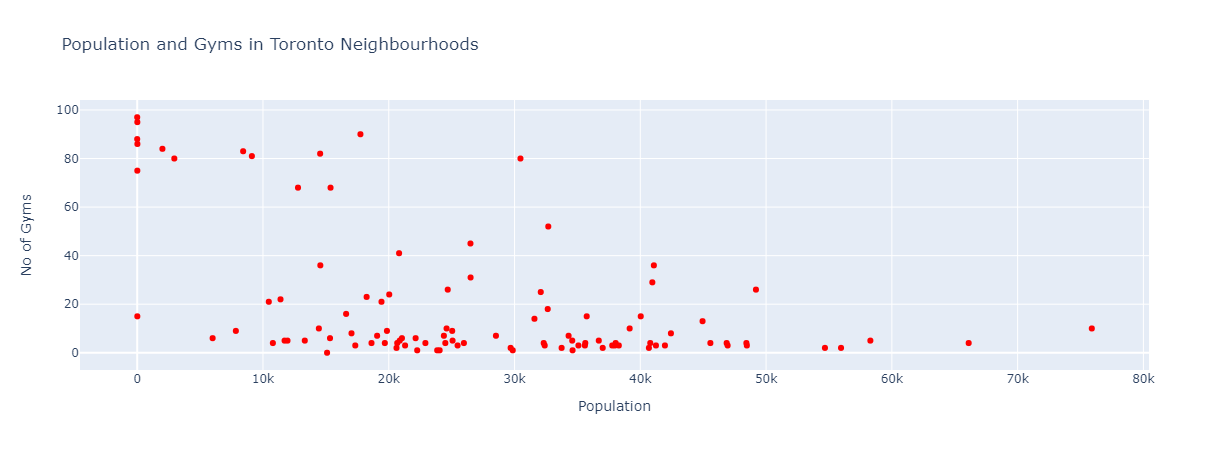

In [74]:
# First we create a figure using go.Figure and adding trace to it through go.scatter
fig = go.Figure(data=go.Scatter(x=fin_toronto['Population'], y=fin_toronto['Gyms'], mode='markers', marker=dict(color='red')))
# Updating layout through `update_layout`. Here we are adding title to the plot and providing title to x and y axis.
fig.update_layout(title='Population and Gyms in Toronto Neighbourhoods', xaxis_title='Population', yaxis_title='No of Gyms')
# Display the figure
fig.show()

Surprisingly we see that there is negative correlation between population and number of gyms in neighborhood. It gives us a hint that Toronto residents have a habit to visit Gym when they are going to or coming from work, so the gyms are also located more in the commercial neighborhoods than residential. 

It gives us an **idea** - now, during the COVID crises, more people have used to work from home and many probably stay working from the home also after the crisis. When gyms are located in the commercial area it is high probability that the demand for near-the-home gyms will grow. So, we stay on our path to look for neighborhoods with less gyms per population.

### It seems that everything is ready for clustering <a name="Step3"></a>

In [75]:
# set number of clusters
kclusters = 5

toronto_fin_clustering = fin_toronto[['Population','Gyms']]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_fin_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]  

array([0, 4, 2, 4, 1, 0, 3, 1, 4, 1], dtype=int32)

Lets insert Cluster labels to final Toronto dataframe

In [76]:
fin_toronto.insert(0, 'Cluster', kmeans.labels_)
fin_toronto['Cluster'].astype(int)
fin_toronto

,Cluster,PostalCode,Borough,Neighborhood,Latitude,Longitude,Population,Gyms
0,0,M3A,North York,Parkwoods,43.753259,-79.329656,34615.0,1.0
1,4,M4A,North York,Victoria Village,43.725882,-79.315572,14443.0,10.0
2,2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,41078.0,36.0
3,4,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,21048.0,6.0
4,1,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,10.0,75.0
...,...,...,...,...,...,...,...,...
97,1,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,10787.0,4.0
98,0,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,30472.0,80.0
99,1,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558,10.0,15.0
100,4,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,21299.0,3.0


Lets count, how many neighborhoods there are in different clusters

In [77]:
clstr=fin_toronto.groupby('Cluster').count()
clstr

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Population,Gyms
Cluster,,,,,,,
0,24,24,24,24,24,24,24
1,19,19,19,19,19,19,19
2,16,16,16,16,16,16,16
3,5,5,5,5,5,5,5
4,38,38,38,38,38,38,38


### Lets visualize the Clusters on the scatterplot <a name="Step4"></a>

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Text(0, 0.5, 'Gyms')

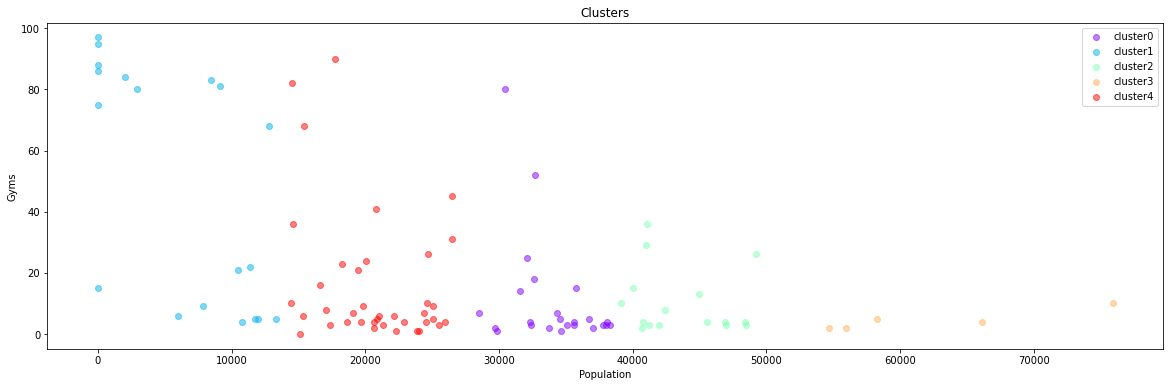

In [90]:
# Initialize the plot with the specified dimensions.
fig_clust = plt.figure(figsize=(20, 6))

n_clusters = max(kmeans.labels_)+1 # add 1 because cluster labels start from 0

# Colors uses a color map, which will produce an array of colors based on
# the number of labels there are. We use set(k_means_labels) to get the
# unique labels.
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))

for color, label in zip(colors, cluster_labels):
    subset = fin_toronto[fin_toronto.Cluster == label]
    plt.scatter(subset.Population, subset.Gyms, c=color, label='cluster'+str(label),alpha=0.5)

plt.legend()
plt.title('Clusters')
plt.xlabel('Population')
plt.ylabel('Gyms')

## Analysis <a name="analysis"></a>

We see that kmeans has clustered neighborhoods using mainly population numbers. 
So we can say roughly that:
* Population 0 - 12 000 is cluster 1
* Population 12 000 - 26 000 is cluster 4
* Population 26 000 - 38 000 is cluster 0
* Population 38 000 - 50 000 is cluster 2
* Population 50 000 + is cluster 3

We can already say that most interesting neighborhoods belong to cluster 3.

In order to create a Choropleth map, we need a GeoJSON file that defines the boundaries of the neighborhoods. I were able to find geoJson coordinates from her

In [39]:
!wget --quiet https://github.com/BlizzWiz/IBM_Capstone_Project/raw/master/toronto_m.geojson
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


### Lets make a choropleth map <a name="Step5"></a>

In [93]:
neighborhood_geo = r'toronto_m.geojson' # geojson file

# first we have to make a plain Toronto map
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=11)

In [94]:
# lets create a numpy array of length 6 and has linear spacing from the minium number of clusters to the maximum number of clusters
threshold_scale = np.linspace(fin_toronto['Cluster'].min(),
                              fin_toronto['Cluster'].max()+1,
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the max number of cluster

# generate choropleth map using the population and number of gyms in each neighborhood
toronto_map.choropleth(
    geo_data=neighborhood_geo,
    data=fin_toronto,
    columns=['PostalCode', 'Cluster'],
    key_on='feature.properties.CFSAUID',
    threshold_scale=threshold_scale,
    fill_color='RdYlBu', 
    fill_opacity=0.7, 
    line_opacity=0.3,
    legend_name='Clusters'
)

# display map
toronto_map

We see that cluster 3 (3-4 - medium blue) which is the most populated cluster, is quite far from the city center. It gives us a reason to believe that rental prices are also cheaper than in downtown area.

Lets see which venues and where each cluster contains

In [95]:
# Cluster 0 
fin_toronto.loc[fin_toronto['Cluster'] == 0, fin_toronto.columns[[3] + list(range(5, fin_toronto.shape[1]))]]

,Neighborhood,Longitude,Population,Gyms
0,Parkwoods,-79.329656,34615.0,1.0
5,Islington Avenue,-79.532242,35594.0,3.0
10,Glencairn,-79.445073,28522.0,7.0
11,"West Deane Park, Princess Gardens, Martin Grov...",-79.554724,32400.0,3.0
12,"Rouge Hill, Port Union, Highland Creek",-79.160497,35626.0,4.0
17,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",-79.577201,38291.0,3.0
21,Caledonia-Fairbanks,-79.453512,38041.0,4.0
22,Woburn,-79.216917,29690.0,2.0
25,Christie,-79.422564,32086.0,25.0
28,"Bathurst Manor, Wilson Heights, Downsview North",-79.442259,37011.0,2.0


In [96]:
# Cluster 1
fin_toronto.loc[fin_toronto['Cluster'] == 1, fin_toronto.columns[[3] + list(range(5, fin_toronto.shape[1]))]]

,Neighborhood,Longitude,Population,Gyms
4,Ontario Provincial Government,-79.389494,10.0,75.0
7,Don Mills North,-79.352188,13324.0,5.0
9,"Garden District, Ryerson",-79.378937,12785.0,68.0
15,St. James Town,-79.375418,2951.0,80.0
20,Berczy Park,-79.373306,9118.0,81.0
24,Central Bay Street,-79.387383,8423.0,83.0
30,"Richmond, Adelaide, King",-79.384568,2005.0,84.0
40,Downsview East,-79.464763,5997.0,6.0
42,"Toronto Dominion Centre, Design Exchange",-79.381576,0.0,97.0
45,"York Mills, Silver Hills",-79.374714,11717.0,5.0


In [97]:
# Cluster 2
fin_toronto.loc[fin_toronto['Cluster'] == 2, fin_toronto.columns[[3] + list(range(5, fin_toronto.shape[1]))]]

,Neighborhood,Longitude,Population,Gyms
2,"Regent Park, Harbourfront",-79.360636,41078.0,36.0
13,Don Mills South,-79.340923,39153.0,10.0
14,Woodbine Heights,-79.318389,46866.0,4.0
18,"Guildwood, Morningside, West Hill",-79.188711,46943.0,3.0
31,"Dufferin, Dovercourt Village",-79.442259,44950.0,13.0
38,"Kennedy Park, Ionview, East Birchmount Park",-79.262029,48434.0,4.0
43,"Brockton, Parkdale Village, Exhibition Place",-79.428191,40957.0,29.0
56,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",-79.476013,42434.0,8.0
60,Downsview Northwest,-79.520999,41958.0,3.0
63,"Runnymede, The Junction North",-79.487262,41243.0,3.0


In [98]:
# Cluster 3
fin_toronto.loc[fin_toronto['Cluster'] == 3, fin_toronto.columns[[3] + list(range(5, fin_toronto.shape[1]))]]

,Neighborhood,Longitude,Population,Gyms
6,"Malvern, Rouge",-79.194353,66108.0,4.0
33,"Fairview, Henry Farm, Oriole",-79.346556,58293.0,5.0
59,Willowdale South,-79.408493,75897.0,10.0
84,"Milliken, Agincourt North, Steeles East, L'Amo...",-79.284577,54680.0,2.0
88,"South Steeles, Silverstone, Humbergate, Jamest...",-79.588437,55959.0,2.0


In [99]:
# Cluster 4
fin_toronto.loc[fin_toronto['Cluster'] == 4, fin_toronto.columns[[3] + list(range(5, fin_toronto.shape[1]))]]

,Neighborhood,Longitude,Population,Gyms
1,Victoria Village,-79.315572,14443.0,10.0
3,"Lawrence Manor, Lawrence Heights",-79.464763,21048.0,6.0
8,"Parkview Hill, Woodbine Gardens",-79.309937,18628.0,4.0
16,Humewood-Cedarvale,-79.428191,24596.0,10.0
19,The Beaches,-79.293031,25044.0,9.0
23,Leaside,-79.363452,19076.0,7.0
26,Cedarbrae,-79.239476,24383.0,7.0
27,Hillcrest Village,-79.363452,24497.0,4.0
29,Thorncliffe Park,-79.349372,19688.0,4.0
34,"Northwood Park, York University",-79.487262,25473.0,3.0


## Results and Discussion <a name="results"></a>

Our analyzis show that considering our aim - to find a neighborhood with big population and minimum number of gyms - 5 best neighborhoods for establishing a gym are:
* Malvern, Rouge. Pop. 66k; 4 gyms
* Fairview, Henry Farm, Oriole. Pop. 58k; 5 gyms
* Willowdale South. Pop. 76k; 10 gyms
* Milliken, Agincourt North.. Pop. 55k; 2 gyms
* South Steeles, Silverstone.. Pop. 56k; 2 gyms

There are lots of people and taking into account that homeoffice has become so popular, people need places to work out closer to home than before.

## Conclusion <a name="conclusion"></a>

Now that we have selected five neighborhoods with biggest market possibilites, we should start a second stage of the research to find out neighborhoods socio-economic indicators.